d:\Python\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1, Loss: 534.2260, Reconstruction Loss: 522.7382, KL Loss: 11.4876
Epoch 2, Loss: 367.9731, Reconstruction Loss: 360.2031, KL Loss: 7.7696
Epoch 3, Loss: 331.7444, Reconstruction Loss: 325.0181, KL Loss: 6.7262
Epoch 4, Loss: 312.0044, Reconstruction Loss: 305.9155, KL Loss: 6.0887
Epoch 5, Loss: 301.1773, Reconstruction Loss: 295.3048, KL Loss: 5.8724
Epoch 6, Loss: 295.3269, Reconstruction Loss: 289.4583, KL Loss: 5.8685
Epoch 7, Loss: 291.4325, Reconstruction Loss: 285.5980, KL Loss: 5.8345
Epoch 8, Loss: 288.6227, Reconstruction Loss: 282.7768, KL Loss: 5.8459
Epoch 9, Loss: 286.5786, Reconstruction Loss: 280.7446, KL Loss: 5.8338
Epoch 10, Loss: 285.1296, Reconstruction Loss: 279.2915, KL Loss: 5.8380


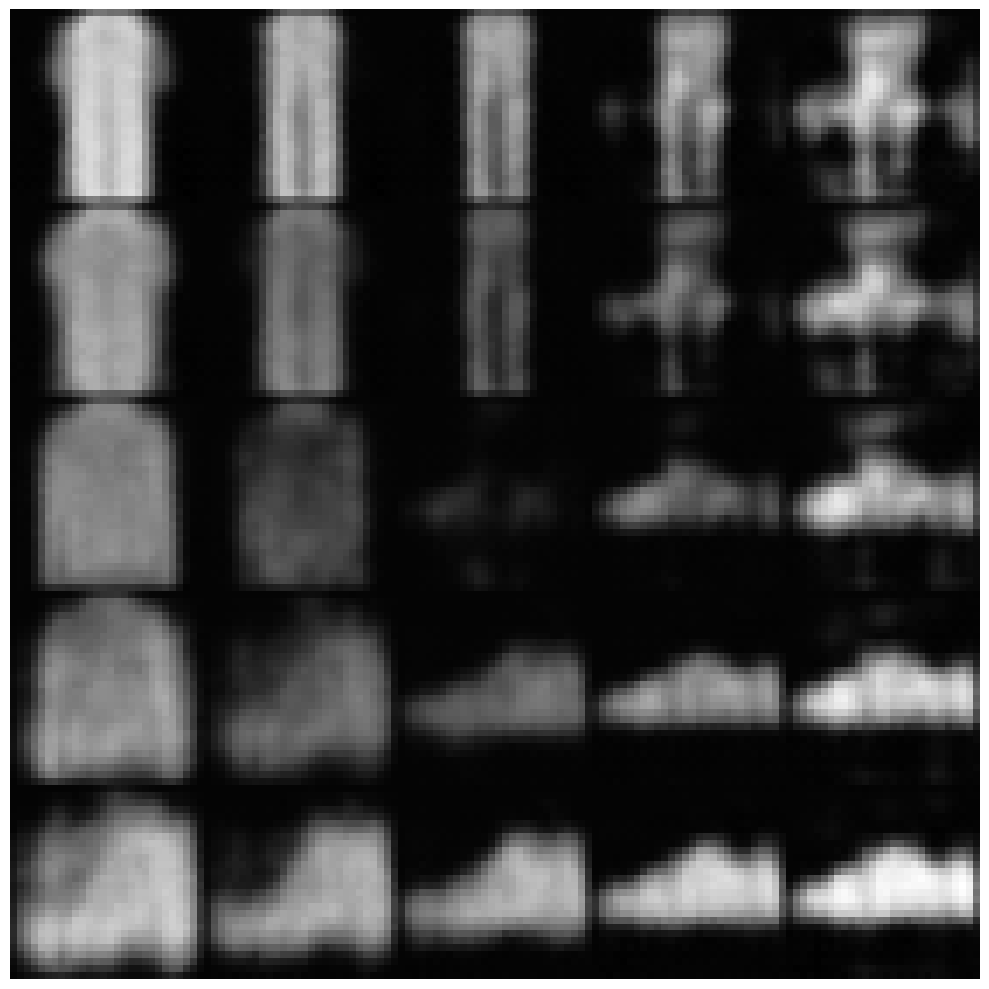

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the Fashion MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# Defining the VAE model
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(7*7*32, activation='relu'),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

# Loss function
def compute_loss(model, x):
    x_recon, mean, logvar = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_recon), axis=(1, 2))
    )
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
    )
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Training step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, recon_loss, kl_loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, recon_loss, kl_loss

# Initialize the model and optimizer
latent_dim = 2
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop
epochs = 10
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

for epoch in range(epochs):
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    for batch in train_dataset:
        loss, recon_loss, kl_loss = train_step(vae, batch, optimizer)
        total_loss += loss
        total_recon_loss += recon_loss
        total_kl_loss += kl_loss
    
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_dataset):.4f}, '
          f'Reconstruction Loss: {total_recon_loss/len(train_dataset):.4f}, '
          f'KL Loss: {total_kl_loss/len(train_dataset):.4f}')

# Generate some samples
n = 5
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1.5, 1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decode(z_sample)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()
plt.show()